In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/lunarcheung/Public/JuliaCode/JuliaProject/plots-gallery/math"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using CairoMakie,Distributions,Turing,LinearAlgebra
using Plots,StatsPlots
import CairoMakie:wireframe!,scatter!

In [3]:
xs=ys=Vector(1:0.05:2)
zs1=[-1+6*x+10*y for x in xs ,y in ys]
zs2=[0 for x in xs, y in ys]

21×21 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  

In [4]:
function plot_wireframe(zs::Matrix)
    fig=Figure()
    ax=Axis3(fig[1,1],azimuth=-pi/4)
    wireframe!(ax,xs,ys,zs)
    fig
end

function plot_wireframe(zs1::Matrix,zs2::Matrix)
    fig=Figure()
    ax=Axis3(fig[1,1],azimuth=-pi/4)
    wireframe!(ax,xs,ys,zs1,color=:green)
    wireframe!(ax,xs,ys,zs2,color=:red)
    
    fig
end

plot_wireframe (generic function with 2 methods)

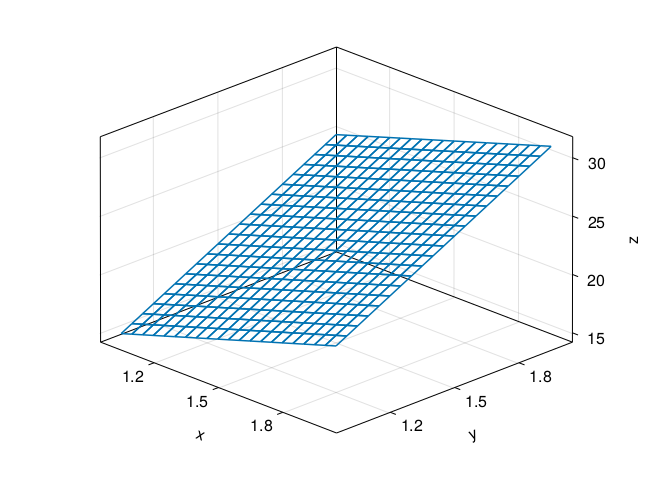

In [5]:
#| label: fig-plane-in-3d-space
#| fig-cap: plane-in-3d-space
#| fig-cap-location: margin
#| fig-align: center
plot_wireframe(zs1)

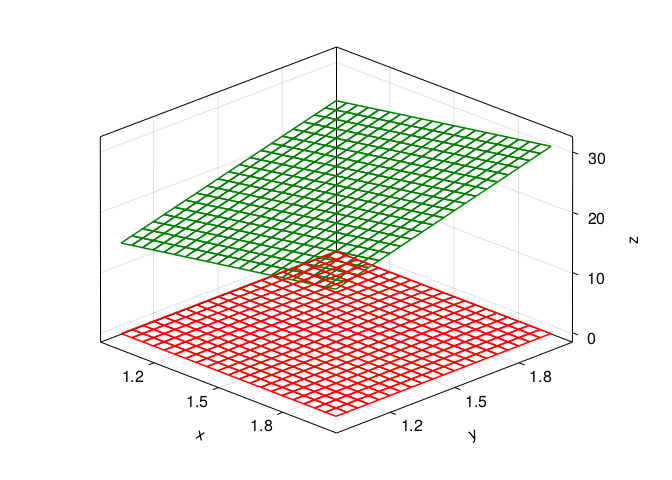

In [6]:
#| label: fig-plane-and-projection-in-2d-plane
#| fig-cap: plane-and-projection-in 2d plane
#| fig-cap-location: margin
#| fig-align: center
plot_wireframe(zs1,zs2)

In [7]:
d=Normal(0,2)
zs4=[[x,y,-1+6*x+10*y+rand(d)] for x in xs  for y in ys]
matrix=hcat(zs4...)

3×441 Matrix{Float64}:
  1.0      1.0      1.0      1.0     …   2.0      2.0      2.0      2.0
  1.0      1.05     1.1      1.15        1.85     1.9      1.95     2.0
 15.4722  17.5936  15.6399  17.2154     26.8933  29.1061  29.4819  33.3816

In [8]:
σs=[0.0,0.05,0.1,1,1.5,3]
dists=[Normal(0,σ) for σ in σs ]

6-element Vector{Normal{Float64}}:
 Normal{Float64}(μ=0.0, σ=0.0)
 Normal{Float64}(μ=0.0, σ=0.05)
 Normal{Float64}(μ=0.0, σ=0.1)
 Normal{Float64}(μ=0.0, σ=1.0)
 Normal{Float64}(μ=0.0, σ=1.5)
 Normal{Float64}(μ=0.0, σ=3.0)

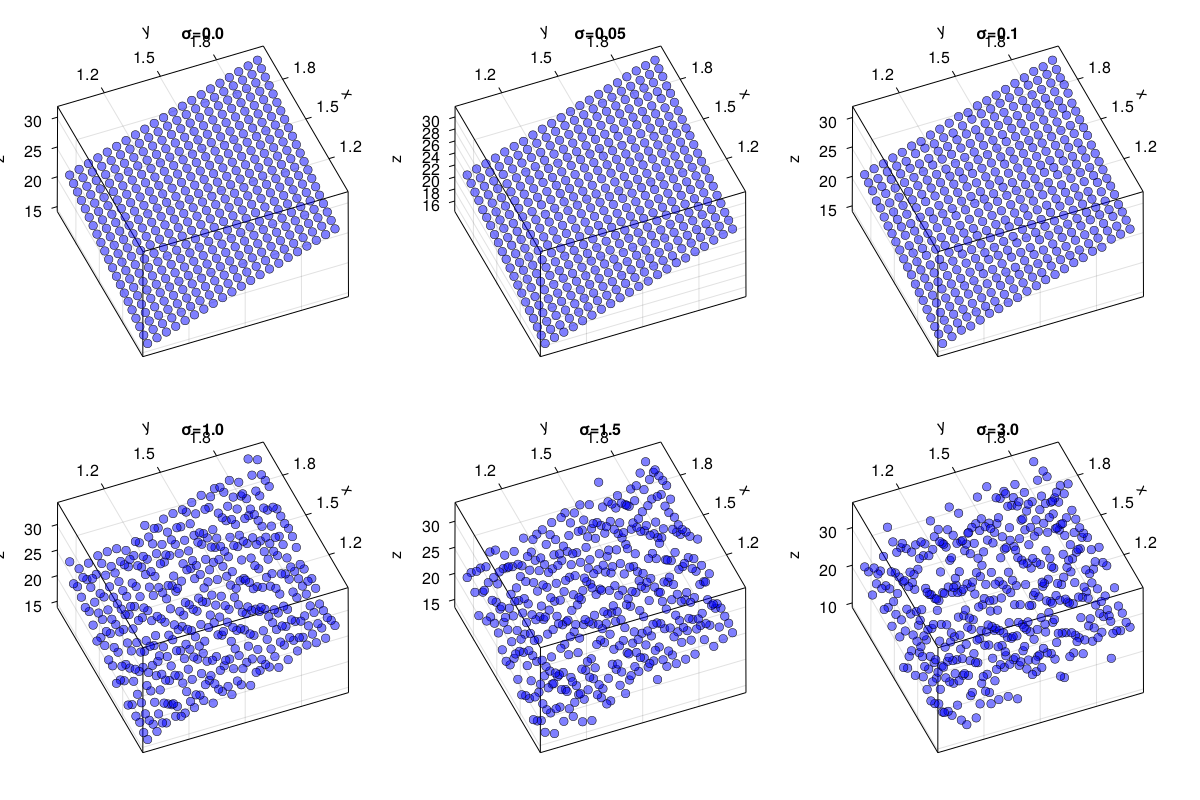

In [9]:
function plot_matrix_arr()
    fig=Figure(resolution=(1200,800))
    
     for  idx in eachindex(dists)
          zs=[[x,y,-1+6*x+10*y+rand(dists[idx])] for x in xs  for y in ys]
          matrix=hcat(zs...)
          ax=Axis3(fig[fldmod1(idx,3)...],title="σ=$(σs[idx])",azimuth=pi/8,elevation=-pi/4)
          scatter!(ax,matrix,color=(:blue,0.5),strokewidth=0.5, strokecolor=:black)
     end
     fig
end
plot_matrix_arr()

In [10]:
d=Normal(0,3)
zs=[-1+6*x+10*y+rand(d) for x in xs  for y in ys]
X=hcat(xs,ys)

21×2 Matrix{Float64}:
 1.0   1.0
 1.05  1.05
 1.1   1.1
 1.15  1.15
 1.2   1.2
 1.25  1.25
 1.3   1.3
 1.35  1.35
 1.4   1.4
 1.45  1.45
 1.5   1.5
 1.55  1.55
 1.6   1.6
 1.65  1.65
 1.7   1.7
 1.75  1.75
 1.8   1.8
 1.85  1.85
 1.9   1.9
 1.95  1.95
 2.0   2.0

In [11]:
@model  function linear_regression(X,y)
       n = length(y)
       mu=[-1+6*x+10*y  for x in X[:,1]  for y in X[:,2]]
       σ² ~ truncated(Normal(0, 5); lower=0)
       for i in 1:n
       y[i] ~ Normal(mu[i], σ²)
       
    end
end

linear_regression (generic function with 2 methods)

In [12]:
model = linear_regression(X,zs)
chain = sample(model, NUTS(), 5_000)

┌ Info: Found initial step size
└   ϵ = 0.00625


Sampling:  20%|████████▎                                |  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (5000×13×1 Array{Float64, 3}):

Iterations        = 1001:1:6000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 7.53 seconds
Compute duration  = 7.53 seconds
parameters        = σ²
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          σ²    2.8191    0.0944     0.0013    0.0019   2258.7134    1.0000    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          σ²    2.6411    2.7545    2.8171    2.8807    3.0125


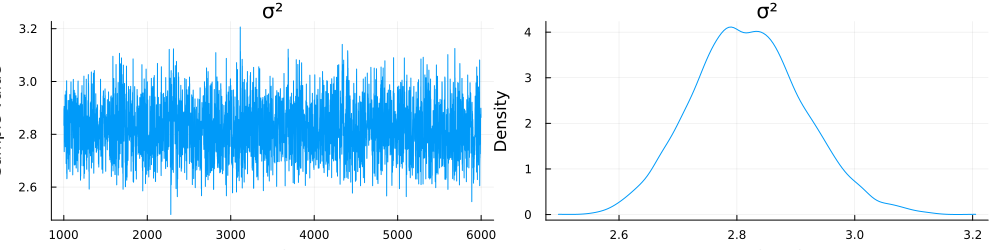

In [13]:
Plots.plot(chain)